In [1]:
from FeatureExtractor import get_data
from plotutils import model_history,c_report,plot_confusion_matrix
import numpy as np
from tensorflow import keras
import sklearn
from keras.models import  Model
from keras.layers import *
from keras.regularizers import *
from keras.layers import BatchNormalization
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from keras.callbacks import *
import numpy as np
import pandas as pd

In [2]:
# read data and call get_data function to get splits of data
emodb_data = pd.read_csv('Downloads/Emodb_dataset.csv')

In [3]:
from sklearn.preprocessing import LabelEncoder
label=LabelEncoder()
z=label.fit_transform(emodb_data['labels'])

In [4]:
emodb_data['labels']=z

In [5]:
X_train, Y_train, X_test, Y_test = get_data()

In [6]:
Y_train = keras.utils.to_categorical(Y_train,7)
Y_test = keras.utils.to_categorical(Y_test,7)

In [7]:
Y=np.array(emodb_data.labels)
from sklearn.utils.class_weight import compute_class_weight
weight = compute_class_weight(class_weight='balanced', classes=np.unique(Y), y=Y)
weight = {i : weight[i] for i in range(4)}

In [8]:
#CNNModel
input1 = Input(shape=(X_train.shape[1], X_train.shape[2], 1))
# First Conv2D block
conv1 = Conv2D(100, kernel_size=(3, 3),strides=(2, 2),activation=None,padding='same',
               kernel_initializer='he_normal', kernel_regularizer=l2(0.002), bias_regularizer=l2(0.001))(input1)
batch1 = BatchNormalization()(conv1)
elu1 = ELU(alpha=1.0)(batch1)
pool1 = MaxPooling2D(pool_size=(2, 2),strides=(1,1))(elu1)
dropout1 = Dropout(0.5)(pool1)

# Second Conv2D block
conv2 = Conv2D(100, kernel_size=(3, 3),strides=(2, 2),padding='same',
               activation=None,kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001) )(dropout1)
batch2 = BatchNormalization()(conv2)
elu2 = ELU(alpha=1.0)(batch2)
pool2 = MaxPooling2D(pool_size=(2,2),strides=(1,1))(elu2)
dropout2 = Dropout(0.5)(pool2)

conv3 = Conv2D(100, kernel_size=(3, 3),strides=(2, 2),activation=None,padding='same',
               kernel_regularizer=l2(0.002), bias_regularizer=l2(0.001))(dropout2)
batch3 = BatchNormalization()(conv3)
elu3 = ELU(alpha=1.0)(batch3)
pool3 = MaxPooling2D(pool_size=(2, 2),strides=(1,1))(elu3)
dropout3 = Dropout(0.5)(pool3)

conv4 = Conv2D(100, kernel_size=(3, 3),strides=(2, 2),activation=None,padding='same',
                kernel_regularizer=l2(0.002), bias_regularizer=l2(0.001))(dropout3)
batch4 = BatchNormalization()(conv4)
elu4 = ELU(alpha=1.0)(batch4)
pool4 = MaxPooling2D(pool_size=(2, 2),strides=(1,1))(elu4)
dropout4 = Dropout(0.5)(pool4)

In [9]:
#DNNModel
flat1=Flatten()(dropout4)
dense1=Dense(1024,activation="relu",kernel_regularizer=l1(0.0001))(flat1)
batch5=BatchNormalization()(dense1)
dropout5=Dropout(0.5)(batch5)
dense2=Dense(1024,activation="relu",kernel_regularizer=l1(0.0001))(dropout5)
batch6=BatchNormalization()(dense2)
dropout6=Dropout(0.5)(batch6)

In [10]:
#LSTMModel
reshape1 = Reshape((4*8, 32))(dropout6)
lstm1 = Bidirectional(LSTM(512, return_sequences = True,))(reshape1)
flat1 = Flatten()(lstm1)
lstm2 = Bidirectional(LSTM(256, return_sequences = True,))(reshape1)
flat2 = Flatten()(lstm2)

In [11]:
den1 = Dense(64, activation='relu',kernel_regularizer=l2(0.002))(flat1)
den2 = Dense(7, activation='softmax')(den1)

In [12]:
model= Model(inputs=input1,outputs=den2)

# Early stopping callback tracking val_loss
stop_early = EarlyStopping(monitor='val_loss', mode='min',
                           verbose=1, patience=15)

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 274, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 64, 137, 100)      1000      
                                                                 
 batch_normalization (BatchN  (None, 64, 137, 100)     400       
 ormalization)                                                   
                                                                 
 elu (ELU)                   (None, 64, 137, 100)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 136, 100)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 136, 100)      0     

In [14]:
# Model Checkpoint callback tracking val_accuracy
checkpoint = ModelCheckpoint(
    'model1.h5', 
    monitor = 'val_accuracy', 
    verbose = 1, 
    save_best_only = True
)

In [15]:
model.compile(optimizer='adam',loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),metrics=['accuracy'])
model

In [16]:
history = model.fit(X_train, Y_train, validation_split=0.15, class_weight = weight, batch_size=32,epochs = 150,callbacks=[checkpoint,stop_early])

Epoch 1/150
8/8 [==============================] - ETA: 0s - loss: 17.9420 - accuracy: 0.3577
Epoch 1: val_accuracy improved from -inf to 0.45455, saving model to model1.h5
8/8 [==============================] - 57s 5s/step - loss: 17.9420 - accuracy: 0.3577 - val_loss: 24.6692 - val_accuracy: 0.4545
Epoch 2/150
8/8 [==============================] - ETA: 0s - loss: 16.8621 - accuracy: 0.5081
Epoch 2: val_accuracy did not improve from 0.45455
8/8 [==============================] - 27s 3s/step - loss: 16.8621 - accuracy: 0.5081 - val_loss: 23.3399 - val_accuracy: 0.4545
Epoch 3/150
8/8 [==============================] - ETA: 0s - loss: 15.8412 - accuracy: 0.6220
Epoch 3: val_accuracy improved from 0.45455 to 0.47727, saving model to model1.h5
8/8 [==============================] - 31s 4s/step - loss: 15.8412 - accuracy: 0.6220 - val_loss: 19.8326 - val_accuracy: 0.4773
Epoch 4/150
8/8 [==============================] - ETA: 0s - loss: 15.1787 - accuracy: 0.6341
Epoch 4: val_accuracy imp

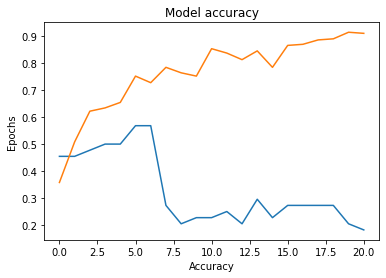

In [17]:
import matplotlib.pyplot as plt
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])
plt.title("Model accuracy")
plt.xlabel("Accuracy")
plt.ylabel("Epochs")
plt.show()

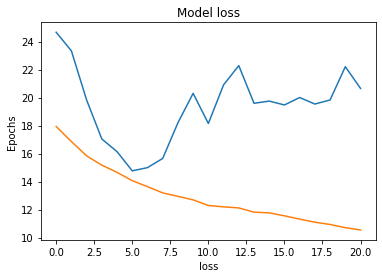

In [18]:
import matplotlib.pyplot as plt
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title("Model loss")
plt.xlabel("loss")
plt.ylabel("Epochs")
plt.show()

In [19]:
predict = model.predict(X_test)
loss, accu = model.evaluate(X_test,Y_test,verbose=1)
labels_pred = np.argmax(predict, axis = -1)    
labels_true = np.argmax(Y_test, axis = -1)

2/2 [==============================] - 3s 239ms/step - loss: 18.3088 - accuracy: 0.3030


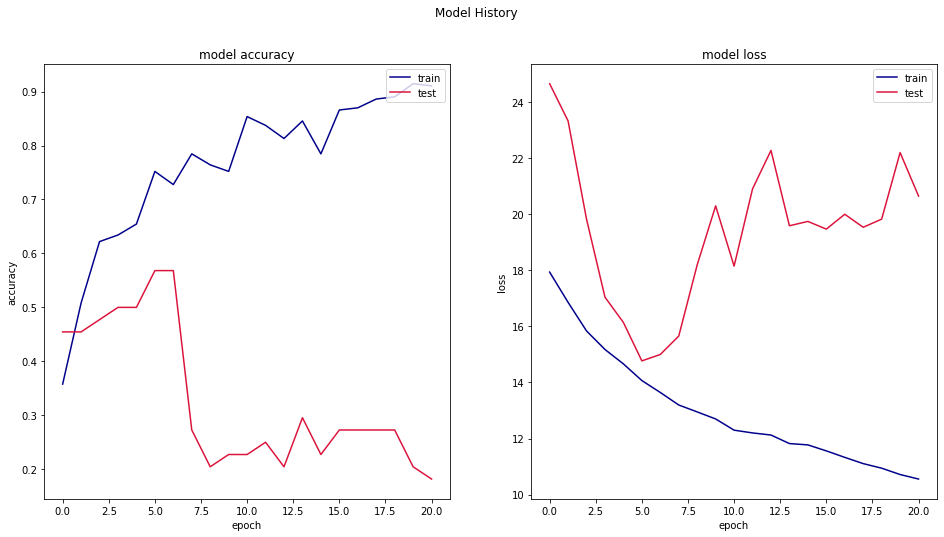

In [20]:
model_history(history)

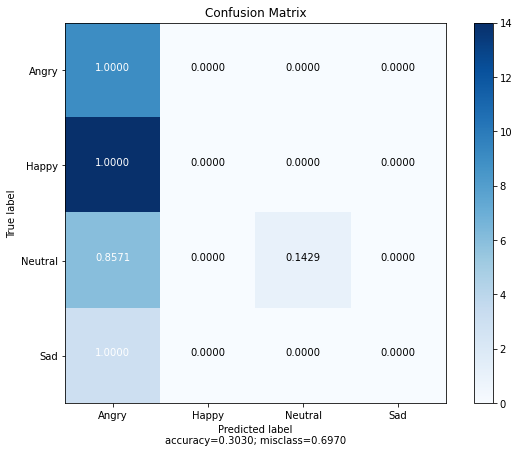

In [21]:
plot_confusion_matrix(cm = confusion_matrix(labels_true, labels_pred),normalize = True,
                    target_names =['Angry','Happy', 'Neutral', 'Sad'],title = "Confusion Matrix")
